# Porting LSST test queries to Stripe82++ : part 1

Notebook with queries representing the LSST test queries, but against the Stripe82 database. The latter was extended with a 'match' and 'coadd' table following script in 
https://docs.google.com/document/d/1qFOE1s4bQUDM8W7wLzoxb2OK1LaPwzd5Lmy_GKUYut0.

Queries from https://dev.lsstcorp.org/trac/wiki/db/queries

Assuming schema S12_sdss from https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=S12_sdss

Ths notebook is in http://github.com/jhu-lsst/Stripe82/test_queries/LSST-Test-Queries.ipynb

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import skimage.io                   # image processing library


import SciServer.CasJobs as cj
import SciServer.SkyServer as skyS

In [2]:
# define some variable to be used in query execution
TARGET_CONTEXT="Stripe82_016"


In [8]:
# SLOW
sql="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM test.coadd as c
  inner join photoobjall AS p
  on c.cobjid=p.objid
  and p.type=3
  and p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""
df=cj.executeQuery(sql,TARGET_CONTEXT)
#g=pandas.read_csv(gals)
df

,objId,ra,dec,petror90_r
0,8647474690330001465,349.724235,-1.060240,23.09696
1,8647474690346647696,27.805763,-1.060708,11.91580
2,8647474690885943524,33.409822,-0.717293,24.46484
3,8647474690344288276,22.360746,-1.199770,14.98176
4,8647474690344288366,22.433274,-1.241417,21.70089
5,8647474690344091714,21.929203,-1.139579,19.55241
6,8647474690341535789,16.069998,-1.074973,12.38839
7,8647474690340094169,12.875283,-1.253097,16.75119
8,8647474690337210627,6.313045,-1.111743,17.18873
9,8647474691427205227,43.365252,-0.232934,35.34655


In [9]:
OBJECT_ID=8647474690330001465

### <a href="https://dev.lsstcorp.org/trac/wiki/db/queries/001" target="_blank">Extract light curve for a given object (time, magnitude and/or position) </a>

https://dev.lsstcorp.org/trac/wiki/db/queries/001

QSERV
```sql
SELECT taiMidPoint, psfFlux, psfFluxSigma, ra, decl
FROM   Source
JOIN   Filter USING (filterId)
WHERE  objectId = :objectId
   AND filterName = :filterName
```

In [10]:
# LSST schema apparently has one row per filter, SDSS does not.
# Maybe we should make a version of Source similar to the LSST schema.

sql="""
select s.cobjid,p.objid,distance,p.ra,p.dec
  , p.psfMag_u, p.psfMagErr_u, f.mjd_u
  , p.psfMag_g, p.psfMagErr_g, f.mjd_g
  , p.psfMag_r, p.psfMagErr_r, f.mjd_r
  , p.psfMag_i, p.psfMagErr_i, f.mjd_i
  , p.psfMag_z, p.psfMagErr_z, f.mjd_z
  from test.coadd o
    inner join test.match s
       on s.cobjid=o.cobjid
    inner join field f
       on f.fieldid=s.fieldid
    inner join PhotoobjAll p
       on s.objId=p.objid
 where o.cobjId=%d
order by mjd_u
""" % OBJECT_ID
df=cj.executeQuery(sql,TARGET_CONTEXT)
df.head()

,cobjid,objid,distance,ra,dec,psfMag_u,psfMagErr_u,mjd_u,psfMag_g,psfMagErr_g,mjd_g,psfMag_r,psfMagErr_r,mjd_r,psfMag_i,psfMagErr_i,mjd_i,psfMag_z,psfMagErr_z,mjd_z
0,8647474690330001465,8658466039902175332,0.000311,349.724239,-1.060243,18.41260,0.022433,52522.287480,16.47759,0.014918,52522.289138,15.72243,0.013041,52522.285821,15.15400,0.013235,52522.286650,14.75574,0.017625,52522.288309
1,8647474690330001465,8658466190242611309,0.001378,349.724222,-1.060259,18.40801,0.021843,52552.282979,16.65211,0.014700,52552.284638,15.62957,0.015708,52552.281321,15.30032,0.016148,52552.282150,14.88935,0.019307,52552.283808
2,8647474690330001465,8658184835522297899,0.000985,349.724228,-1.060255,18.47959,0.021842,52558.291688,16.52384,0.026021,52558.293346,15.80437,0.021307,52558.290029,15.34419,0.014687,52558.290859,14.86849,0.016133,52558.292517
3,8647474690330001465,8658185033092956243,0.001085,349.724231,-1.060258,18.30349,0.019503,52577.179048,16.43655,0.014850,52577.180707,15.54165,0.013923,52577.177389,15.13418,0.015636,52577.178219,14.79658,0.013272,52577.179877
4,8647474690330001465,8658185166229078036,0.001689,349.724224,-1.060266,18.36794,0.020366,52586.182742,16.63336,0.020180,52586.184401,15.76468,0.014221,52586.181083,15.25009,0.015351,52586.181913,14.88255,0.015196,52586.183571


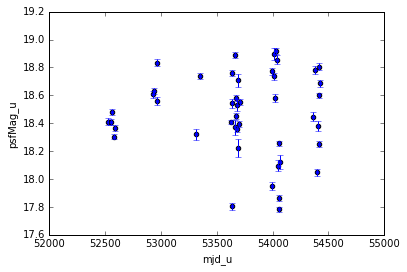

In [11]:
x="mjd_u"
y="psfMag_u"
yerr="psfMagErr_u"
plt.scatter(df[x],df[y])
plt.errorbar(df[x],df[y],yerr=df[yerr], linestyle="None")
plt.xlabel(x)
plt.ylabel(y)

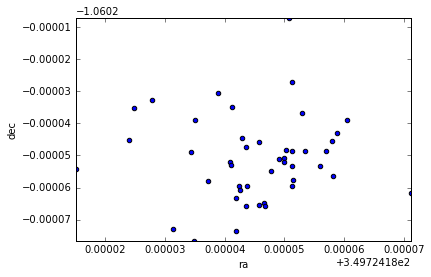

In [12]:
x="ra"
y="dec"
plt.scatter(df[x],df[y])
xlim=(np.min(df[x]),np.max(df[x]))
ylim=(np.min(df[y]),np.max(df[y]))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel(x)
plt.ylabel(y)

### Select the full color image of a single (given) galaxy

QSERV

To complete this request we need to run a database query that selects the galaxy based on a given objectId, determines its ra, decl and size as well as corresponding exposureId. Since the epoch is not specified, the most recent one will be fetched.
Generate image cut out through Cutout Service.
The database query:

```sql
SELECT s.ra, s.decl, o.raRange, o.declRange
FROM   Object o
JOIN   Source s USING (objectId)
WHERE  o.objectId = :objectId
AND    o.latestObsTime = s.taiMidPoint
```

In [13]:
# we will do this using the cutout service url that is provided and connect to skyserver to get it.
sql="""
select ra,dec,petror90_r
  from photoobjall
 where objid= %s
""" % OBJECT_ID
df= cj.executeQuery(sql,TARGET_CONTEXT)

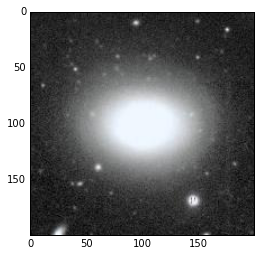

In [14]:
width=200
height=200
pixelsize=0.396

ra=df['ra'][0]
dec= df['dec'][0]
petror90_r=df['petror90_r'][0]

# the 'scale' parameter is set so that the image will be about 2x the size of the galaxy
scale=2*petror90_r/pixelsize/width
if False:
    img=skyS.getJpegImgCutout(ra,dec, scale=scale, width=width, height=height, opt="", query="", dataRelease='DR13')
else:
    url="http://skyservice.pha.jhu.edu/Stripe82/ImgCutout/getjpeg.aspx?ra="+str(ra)
    url+="&dec="+str(dec)+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    img=skimage.io.imread(url)
plt.imshow(img)

### Find an object with a particular objectId

QSERV
```sql
SELECT *
FROM   Object
WHERE  objectId = :objectId
```
Origin: this query came from SDSS (SX-4).


In [15]:

sql="""
select * from test.coadd
where cobjId=%d""" % OBJECT_ID
df=cj.executeQuery(sql,TARGET_CONTEXT)
df

,cobjid,type,ra,dec,cx,cy,cz,u,g,r,i,z,c,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z
0,8647474690330001465,3,-10.275765,-1.06024,0.983792,-0.178356,-0.018504,18.38881,16.54506,15.78646,15.35675,14.90072,2.614587,0.003548,0.00057,0.000393,0.000364,0.000647


### Select variable objects near a known galaxy

QSERV
```sql
SELECT v.objectId, v.ra, v.decl
FROM   Object v, Object o
WHERE  o.objectId = :objectId
   AND spDist(v.ra, v.decl, o.ra, o.decl, :dist)
   AND v.variability > 0.8
   AND o.extendedParameter > 0.8
```

In [ ]:
# Q: how are 'variabe objects' defined?
# Can we do this for our coadd/match tables?


### Give me astrometry for a given moving object

This query was suggested by the LSST Science Collaboration (Solar System)

QSERV
```sql
SELECT diaSourceId, ra, decl
FROM   DiaSource
WHERE  movingObjectId = :movingObjectId
```

In [ ]:
# Q: how are 'moving objects' defined?
# Can we do this for our coadd/match tables?


### tbd